<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 24.82 MiB/s, done.
Resolving deltas: 100% (712/712), done.


In [2]:
%cd course22p2

/content/course22p2


In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.0 MB/s eta 0:00:00


In [5]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from fastprogress import progress_bar, master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [6]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

In [7]:
x, y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2080: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [9]:
bs = 256
tds = dsd.with_transform(transformi)

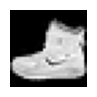

In [10]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [11]:
cf = collate_dict(ds)

In [12]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [13]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [14]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [15]:
labels = ds.features[y].names

In [16]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [17]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

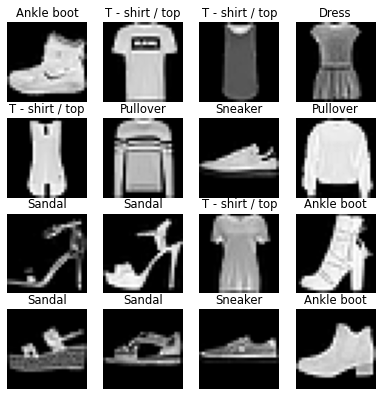

In [18]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

In [19]:
from torch import optim

bs = 256
lr = 0.4

In [20]:
cnn = nn.Sequential(
    conv(1, 4), #14x14
    conv(4, 8), #7x7
    conv(8, 16), #4x4
    conv(16, 16), #2x2
    conv(16, 10, act=False), #1x1
    nn.Flatten().to(def_device)
)

In [21]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.7979391932964325 0.7065
1 0.651333419084549 0.7709
2 0.5198538362503051 0.8104
3 0.48681648128032684 0.8207
4 0.455131773519516 0.836


In [23]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [25]:
def deconv(ni, nf, ks=3, act=True):
  layers = [nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [26]:
def fit(epochs, model, loss_func, opt, train_dl,  valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb,_ in train_dl:
      loss = loss_func(model(xb), xb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    eval(model, loss_func, valid_dl, epoch)

In [35]:
def eval(model, loss_func, valid_dl, epoch=0):
  model.eval()
  with torch.no_grad():
    tot_loss, count = 0.,0
    for xb,_ in valid_dl:
      pred = model(xb)
      n = len(xb)
      count += n
      tot_loss += loss_func(pred, xb).item()*n
  print(epoch, f'{tot_loss/count:.3f}')

In [33]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [36]:
eval(ae, F.mse_loss, dv)

0 0.155


In [43]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.138
1 0.130
2 0.126
3 0.125
4 0.124


In [44]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.111
1 0.041
2 0.032
3 0.029
4 0.028


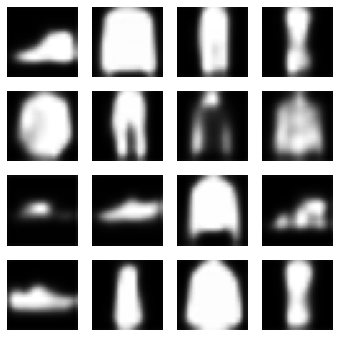

In [45]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

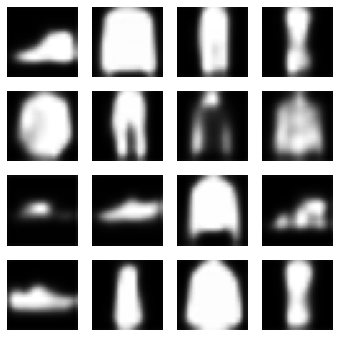

In [46]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

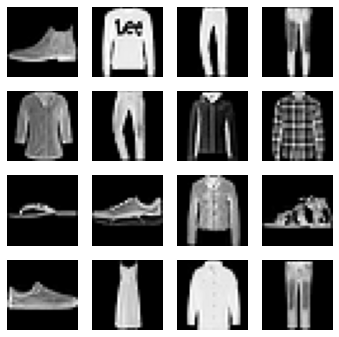

In [47]:
show_images(xb[:16].data.cpu(), imsize=1.5)